# Document Classification
---
## Comparision of TF-IDF Method and Naive Bayes Method

For the dataset we have taken the StackOverflow Text Classification problem dataset from HackerRank. 

The problem is as follows - 
*Stack Exchange is an information powerhouse, built on the power of crowdsourcing. It has 105 different topics and each topic has a library of questions which have been asked and answered by knowledgeable members of the StackExchange community. The topics are as diverse as travel, cooking, programming, engineering and photography.*

*We have hand-picked ten different topics (such as Electronics, Mathematics, Photography etc.) from Stack Exchange, and we provide you with a set of questions from these topics.*

*Given a question and an excerpt, your task is to identify which among the 10 topics it belongs to.*

Based on the above dataset, we implemented two algorithms to solve the problem. We have analysed the text by testing the impact of number of stopwords has on the overall accuracy of the prediction, and compared the performance of the these two methods. 

In [3]:
import math
import sys
from decimal import Decimal
import time
import json
import re, string
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline
regex=re.compile('[%s]' % re.escape(string.punctuation))

### Training of TF-IDF Classifier
The following function will train the TF-IDF classifier. 
- It takes as input the filepath of training json file, and the stop word limit. 
- Stop words are the very frequently occuring words in the training set whose value to a class is very less. Hence they only increase the computation during testing. Limit equal to zero implies that we are not creating a list of stop words. Any other value of limit will check for words that have frequency more than the limit in the vocabulary, and then add them to stop words.
- The function returns a dictionary of dictionaries which store the count(*count*) of each word in each class, the vocabulary(*vocab*) of the training data and the list of stop words(*stop*).

In [4]:
def train_tf_idf(filepath, limit):
    
    f=open(filepath)
    n=int(f.readline().strip())
    
    pack={}
    
    counts={}
    vocab={}
    stop={}
    
    for i in range(n):
        obj=json.loads(f.readline().strip())
        e=obj['question']+' '+obj['excerpt']
        t=obj['topic']
        
        if t not in counts:
            counts[t]={}
        
        e=regex.sub('',e)
        elist=e.split()
        
        for word in elist:
            word=word.lower()
            
            if word not in vocab:
                vocab[word]=0
            vocab[word]+=1
            
            if word in counts[t]:
                counts[t][word]+=1
            else:
                counts[t][word]=1
    
    if limit!=0:
        for x in sorted(vocab, key=vocab.get, reverse=True):
            if vocab[x]>limit:
                stop[x]=vocab[x]
                del vocab[x]

    pack.update({'counts':counts})
    pack.update({'vocab':vocab})
    pack.update({'stop':stop})
    return pack

### Testing using TF-IDF Classifier
The following function will test a given test set using the TF-IDF classifier. 
- It takes as input the filepath of training json file, dictionary of count of each word in each class, a dictionary of stop words and a dictionary of vocabulary.
- Each word in the question and excerpt is checked in the *count* dictionary. TF stands for term frequency, ie a score based on count of that word in the class we are considering. IDF stands for inverse document frequency, which gives a score based on how many classes is that word present. The product of these scores gives the TF-IDF score of that word, and the summation of the scores of all words in a question-excerpt sentence is calculated for each class. The class which gives the maximum score is assigned to that test case.
- The function returns a list of predicted output values from the classifier.

In [5]:
def predict_tf_idf(filepath,counts,vocab,stop):
    
    f=open(filepath)
    n=int(f.readline().strip())
    
    l=[str(x) for x in counts.keys()]
    
    out=[]
    local={}
    
    for i in range(n):
        obj=json.loads(f.readline().strip())
        e=obj['question']+' '+obj['excerpt']
        
        scores={x:0.0 for x in l}

        e=regex.sub('',e)
        elist=e.split()
        
        for word in elist:
            word=word.lower()
            if word not in stop:
                if word not in local:
                    local[word]={x:0 for x in l}
                    ccount=0
                    tf={x:0 for x in l}

                    for t in l:
                        if word in counts[t]:
                            ccount+=1
                            tf[t]=(1+math.log10(counts[t][word]))

                    for t in l:
                        if ccount!=0:
                            local[word][t]=tf[t]*math.log10(float(len(l))/ccount)
                        else:
                            local[word][t]=0
                        scores[t]+=local[word][t]
                else:
                    for t in l:
                        scores[t]+=local[word][t]

        maxo=0.0
        topic=''
        for t in l:
            sums=scores[t]
            if sums>maxo:
                maxo=sums
                topic=t
        out.append(str(topic))
    return out

### Training of Naive Bayes Classifier
The following function will train the Naive Bayes classifier. 
- It takes as input the filepath of training json file, and the stop word limit. 
- Stop words are the very frequently occuring words in the training set whose value to a class is very less. Hence they only increase the computation during testing. Limit equal to zero implies that we are not creating a list of stop words. Any other value of limit will check for words that have frequency more than the limit in the vocabulary, and then add them to stop words.
- The function returns a dictionary of dictionaries which store the count of each word in each class(*count_winc*), count of all the words in the class(*count_awinc*), count of documents present in each class(*count_c*), the vocabulary(*vocab*) of the training data and the list of stop words(*stop*).

In [6]:
def train_NB(filepath, limit):
    f=open(filepath)
    n=int(f.readline().strip())
    
    pack={}
    
    count_c={}
    count_winc={}
    count_awinc={}
    vocab={}
    stop={}
    
    for i in range(n):
        obj=json.loads(f.readline().strip())
        e=obj['question']+' '+obj['excerpt']
        c=obj['topic']
        
        if c not in count_c:
            count_c[c]=0
        count_c[c]+=1

        if c not in count_awinc:
            count_awinc[c]=0

        if c not in count_winc:
            count_winc[c]={}

        e=regex.sub('',e)
        elist=e.split()
        
        for word in elist:
            word=word.lower()
            
            count_awinc[c]+=1
            if word not in vocab:
                vocab[word]=0
            vocab[word]+=1

            if word not in count_winc[c]:
                count_winc[c][word]=0
            count_winc[c][word]+=1
    
    if limit!=0:
        for x in sorted(vocab, key=vocab.get, reverse=True):
            if vocab[x]>limit:
                stop[x]=vocab[x]
                del vocab[x]
                
    pack.update({'count_c':count_c})
    pack.update({'count_winc':count_winc})
    pack.update({'count_awinc':count_awinc})
    pack.update({'vocab':vocab})
    pack.update({'stop':stop})
    return pack

### Testing using Naive Bayes Classifier
The following function will test a given test set using the TF-IDF classifier. 
- It takes as input the filepath of training json file, dictionaries which store the count of each word in each class(*count_winc*), count of all the words in the class(*count_awinc*), count of documents present in each class(*count_c*), the vocabulary(*vocab*) of the training data and the list of stop words(*stop*).
- The test document is split into individual words. The probability of each word belonging to each of the 10 classes is calculated. The test document may contain some new words which are not in training document. The probability of such words is approximated by laplace smoothing. 
    - The probability P(Ci/word) of class i given a word w =  (f + 1)/(t+v) 
        - where f = frequency of that word in particular class
        - t is the total number of words in that class
        - v is the length of the vocabulary of the training data
- The function returns a list of predicted output values from the classifier.

In [7]:
def predict_NB(filepath,count_c,count_winc,count_awinc,vocab,stop):
    f=open(filepath)
    n=int(f.readline().strip())
    
    l=[str(x) for x in count_winc.keys()]
    
    globe={}
    out=[]
    length=len(vocab.keys())
    
    for i in range(n):
        obj=json.loads(f.readline().strip())
        e=obj['question']+' '+obj['excerpt']
        
        e=regex.sub('',e)
        elist=e.split()
        
        local={}
        c_prob={x:Decimal(0.0) for x in l}
        
        for word in elist:
            word=word.lower()
            if word not in stop:
                if word not in local:
                    local[word]=0
                local[word]+=1

                if word not in globe:
                    globe[word]={x:0 for x in l}
                    for c in l:
                        if word in count_winc[c]:
                            globe[word][c]=float(count_winc[c][word]+1)/(count_awinc[c]+length)
                        else:
                            globe[word][c]=float(0+1)/(count_awinc[c]+length)

        maxo=Decimal(0.0)
        topic=''
        sums=Decimal(1.0)
        for c in l:
            sums=Decimal(float(count_c[c])/n)
            for x in local.keys():
                sums*=Decimal(math.pow(globe[x][c],local[x]))
            c_prob[c]=sums

        for c in l:
            if c_prob[c]>maxo:
                maxo=c_prob[c]
                topic=str(c)
        out.append(topic)
    return out

In [8]:
#this function will calculate the accuracy of the predictions made by the classifier
def score(filepath,pred):
    f=open(filepath)
    target=[]
    for line in f:
        target.append(str(line.strip()))
    f.close()
    
    cnt=0
    for i in range(len(pred)):
        if pred[i]==target[i]:
            cnt+=1
    return (float(cnt)/len(pred))

In [9]:
#this function will call other functions in the module. it will call them iteratively over a list of stop word
#limits and calculate the tesing times and accuracy for each instance of stop word limit.
def main():
    limit=[0,2000,4000,6000,8000,10000]
    train_tfidf=[]
    train_nb=[]
    pred_tfidf=[]
    pred_nb=[]
    errors_tfidf=[]
    errors_nb=[]
    
    for i in limit:
        start=time.time()
        pack=train_tf_idf('training.json',i)
        train_tfidf.append(time.time()-start)
        
        start=time.time()
        y_tfidf=predict_tf_idf('input00.txt',pack['counts'],pack['vocab'],pack['stop'])
        pred_tfidf.append(time.time()-start)
        
        errors_tfidf.append(1.0-score('output00.txt',y_tfidf))
        
        
        start=time.time()
        pack=train_NB('training.json',i)
        train_nb.append(time.time()-start)
        
        start=time.time()
        y_NB=predict_NB('input00.txt',pack['count_c'],pack['count_winc'],pack['count_awinc'],pack['vocab'],pack['stop'])
        pred_nb.append(time.time()-start)
        
        errors_nb.append(1.0-score('output00.txt',y_NB))
    
    plt.figure(figsize=(16,16))
    
    plt.subplot(2,2,1)
    plt.title('TF-IDF Training and Prediction times')
    plt.plot(limit,train_tfidf,label='train')
    plt.plot(limit,pred_tfidf,label='predict')
    plt.legend(loc="upper right")
    plt.xlabel("Stop Word Limit")
    plt.ylabel("Time Taken in seconds")
    
    plt.subplot(2,2,2)
    plt.title('N.B. Training and Prediction times')
    plt.plot(limit,train_nb,label='train')
    plt.plot(limit,pred_nb,label='predict')
    plt.legend(loc="upper right")
    plt.xlabel("Stop Word Limit")
    plt.ylabel("Time Taken in seconds")
    
    plt.subplot(2,2,3)
    plt.title('TF_IDF Error Behavior')
    plt.plot(limit,errors_tfidf)
    plt.xlabel("Stop Word Limit")
    plt.ylabel("Error Ratio")
    
    plt.subplot(2,2,4)
    plt.title('N.B. Error Behavior')
    plt.plot(limit,errors_nb)
    plt.xlabel("Stop Word Limit")
    plt.ylabel("Error Ratio")
    
    plt.show()

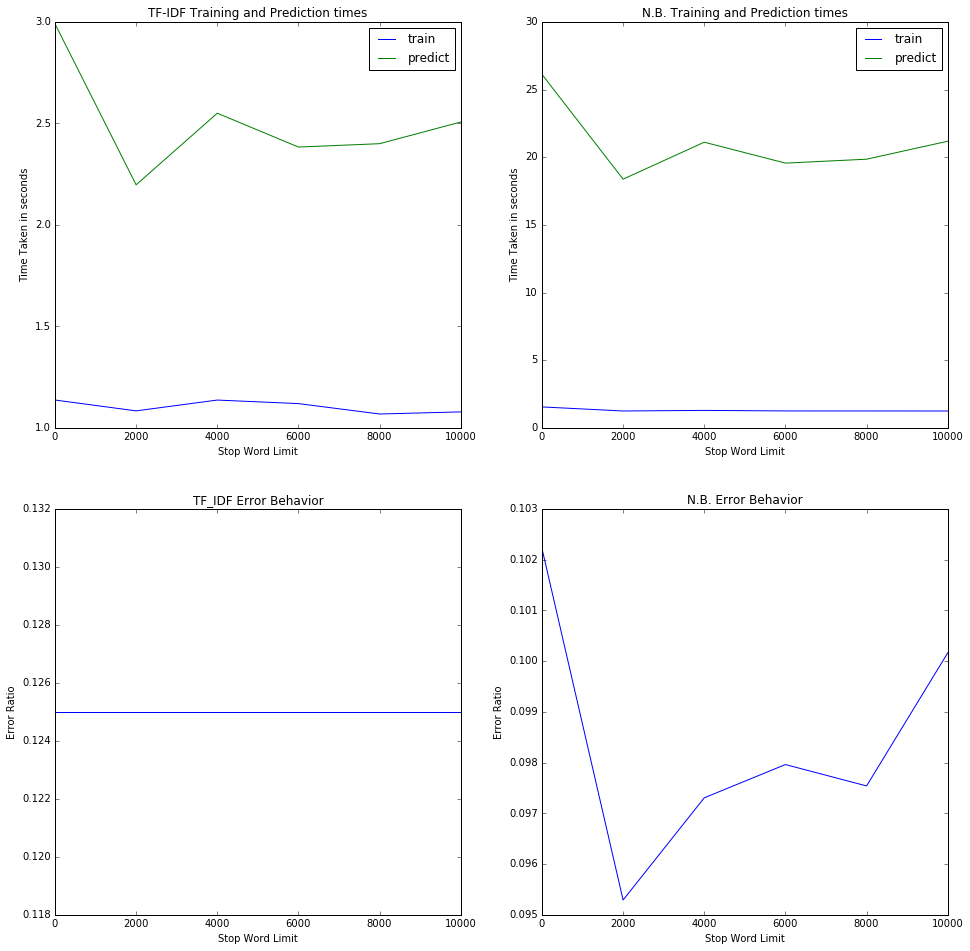

In [10]:
if __name__ == "__main__":main()

## Conclusion
---
- If stop words(words having high frequencies in all classes like the,and etc.) are used for calculating probabilities of classes, the result would not be very efficient because they will have almost equal probabilities for all classes, we need words that belong to particular classes so that probability for those classes are high and classification is done correctly.
- The testing time of algorithm is plotted for different set of stop words. In first set there are no stop words, in second words having frequencies greater than 2000 are considered stop words, third set has limit of stop words as 4000, four fourth set it is 6000, fifth set 8000, sixth set 10000.
- It is noticed that testing time is minumum when words having frequencies greater than 2000 are taken as stop words in both naive bayes and tf-idf.
- The error rate for tf-idf is not affected by stop words. In naive bayes the error rate is minimum when the limit of stop words is 2000(words with frequencies greater than 2000 are considered stop words). 